In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import cv2
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from Trainer import train_model
from Dataloader import JetcarDataset, SimulatorDataset

In [31]:
transforms = torch.nn.Sequential(
    T.RandomResizedCrop(size=(240, 320),scale=(0.5,1)),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4)),
    T.ColorJitter(brightness=.3, hue=.3, saturation=.3),
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
)

In [32]:
realData = JetcarDataset("jetcar_data/data.csv", "jetcar_data/img/", transform=transforms)
x,y = realData[0]
x.shape

(3, 240, 320)

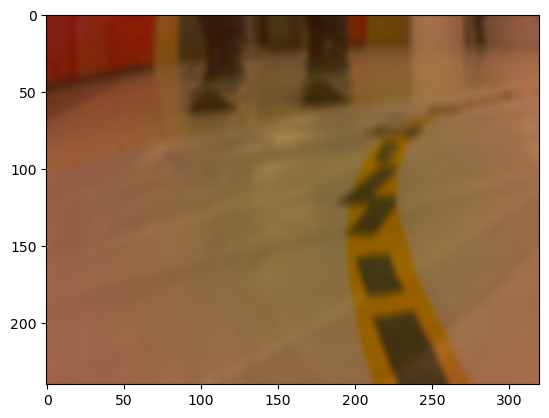

In [33]:
img, label = realData.get_rgb(2)
plt.imshow(img)

In [34]:
train_generator = DataLoader(realData, batch_size=4, shuffle=True)

In [35]:
class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.
        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 (output)
        the convolution layers are meant to handle feature engineering.
        the fully connected layer for predicting the steering angle.
        the elu activation function is for taking care of vanishing gradient problem.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48576, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=2)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 240, 320)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


class LeNet(nn.Module):
    """LeNet architecture."""

    def __init__(self):
        """Initialization."""
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(70224, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 2)

    def forward(self, x):
        """Forward pass."""
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [58]:
model = NetworkNvidia()

In [59]:
print(model)

NetworkNvidia(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=48576, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [60]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
device = torch.device("mps")

In [62]:
model, train_loss, test_loss = train_model(50,model,train_generator,None,criterion,optimizer, device=device)

Epoch: 1/50 	Train Loss: 0.057560
Test loss decreased (inf --> 0.057560. Saving model...
Epoch: 2/50 	Train Loss: 0.056227
Test loss decreased (0.057560 --> 0.056227. Saving model...
Epoch: 3/50 	Train Loss: 0.056105
Test loss decreased (0.056227 --> 0.056105. Saving model...
Epoch: 4/50 	Train Loss: 0.056650
Epoch: 5/50 	Train Loss: 0.055740
Test loss decreased (0.056105 --> 0.055740. Saving model...
Epoch: 6/50 	Train Loss: 0.055702
Test loss decreased (0.055740 --> 0.055702. Saving model...
Epoch: 7/50 	Train Loss: 0.055575
Test loss decreased (0.055702 --> 0.055575. Saving model...
Epoch: 8/50 	Train Loss: 0.055692
Epoch: 9/50 	Train Loss: 0.055264
Test loss decreased (0.055575 --> 0.055264. Saving model...
Epoch: 10/50 	Train Loss: 0.055299
Epoch: 11/50 	Train Loss: 0.055349
Epoch: 12/50 	Train Loss: 0.054883
Test loss decreased (0.055264 --> 0.054883. Saving model...
Epoch: 13/50 	Train Loss: 0.054266
Test loss decreased (0.054883 --> 0.054266. Saving model...
Epoch: 14/50 	Train

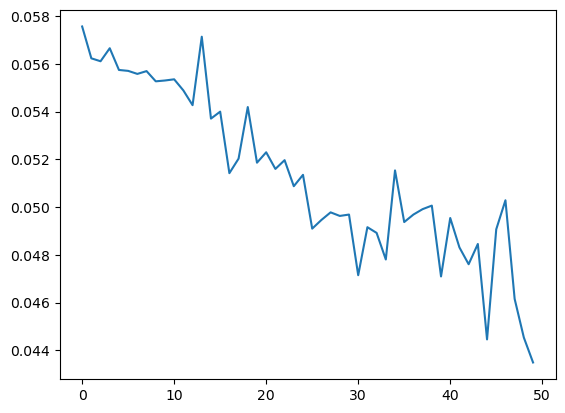

In [63]:
plt.plot(train_loss)

In [64]:
x,y = next(iter(train_generator))
out = model(x.to(device))
print(out)

tensor([[-0.0033,  0.2322],
        [ 0.3576,  0.2110],
        [ 0.5455,  0.2048],
        [ 0.1583,  0.2232]], device='mps:0', grad_fn=<LinearBackward0>)


In [65]:
y

tensor([[0.4227, 0.2371],
        [0.6495, 0.2371],
        [0.6598, 0.2165],
        [0.5876, 0.2165]])

In [66]:
x[1].shape

torch.Size([3, 240, 320])

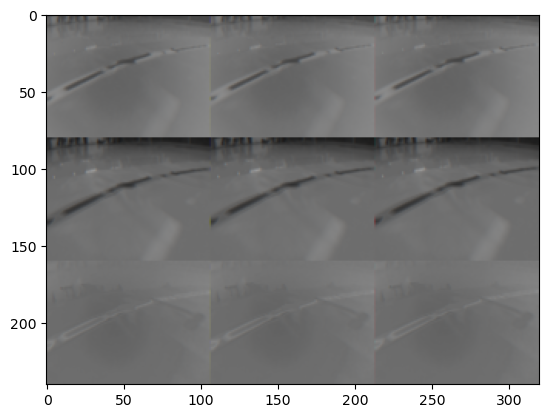

In [72]:
plt.imshow(np.array(x[1].reshape(240,320,3)))

In [85]:
x,y = next(iter(train_generator))
out = model(x.to(device))
print(out)

tensor([[-0.1045,  0.2120],
        [-0.1014,  0.2239],
        [-0.5670,  0.2515],
        [-0.2095,  0.2164]], device='mps:0', grad_fn=<LinearBackward0>)


In [86]:
y

tensor([[ 0.4330,  0.2165],
        [ 0.0618,  0.2165],
        [-1.0000,  0.2371],
        [-0.8660,  0.1753]])

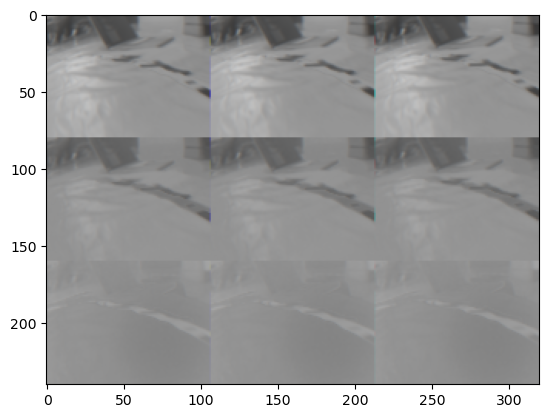

In [91]:
plt.imshow(np.array(x[2].reshape(240,320,3)))

In [99]:
x.max()

tensor(1.)